# Santander Customer Transaction Prediction
---

In this challenge, we need to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

### File descriptions

* **train.csv** - the training set.
* **test.csv** - the test set. The test set contains some rows which are not included in scoring.
* **sample_submission.csv** - a sample submission file in the correct format.

In [1]:
# Load all required packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numba import jit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
import os

%matplotlib inline




## Data Exploration
---

In [2]:
#Read train& test data
os.chdir(r"C:\Users\harsh\Desktop\harsh jain\santander")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [54]:

train.head(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


In [55]:
test.head(10)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
5,test_5,5.9862,-2.2913,8.6058,7.0685,14.2465,-8.6761,4.2467,14.7632,1.8790,...,-2.1115,7.1178,-0.4249,8.8781,14.9438,-2.2151,-6.0233,9.8117,17.1127,10.8240
6,test_6,8.4624,-6.1065,7.3603,8.2627,12.0104,-7.2073,4.1670,13.0809,-4.3004,...,12.3609,6.8661,4.0971,8.8484,17.5010,0.0295,7.7443,9.1509,18.4736,5.1499
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,...,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
8,test_8,6.9856,0.8402,13.7161,4.7749,8.6784,-13.7607,4.3386,14.5843,2.5883,...,-3.4657,7.8754,2.4698,-0.0362,16.7144,0.1221,-1.4328,9.9207,16.9865,-3.3304
9,test_9,10.3811,-6.9348,14.6690,9.0941,11.9058,-10.8018,3.4508,20.2816,-1.4112,...,1.8052,11.0723,0.8907,4.7680,15.1425,0.6075,-4.4447,9.5788,15.8146,9.3457


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [9]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [10]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


In [16]:
train.shape, test.shape

((200000, 202), (200000, 201))

# Target Class Count

In [ ]:
#Target Class Count
target_class=df_train['target'].value_counts()
print('Count of the target class :\n',target_class)

#Percentage of target class count
per_target_class=df_train['target'].value_counts()/len(df_train)*100
print('Percentage of target class count :\n',per_target_class)

In [ ]:
#Count plot & violin plot for target class
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.countplot(df_train.target.values,ax=ax[0],palette='spring')
sns.violinplot(x=df_train.target.values,y=df_train.index.values,ax=ax[1],palette='spring')
sns.stripplot(x=df_train.target.values,y=df_train.index.values,jitter=True,color='black',linewidth=0.5,size=0.5,alpha=0.5,ax=ax[1],palette='spring')
ax[0].set_xlabel('Target')
ax[1].set_xlabel('Target')
ax[1].set_ylabel('Index')

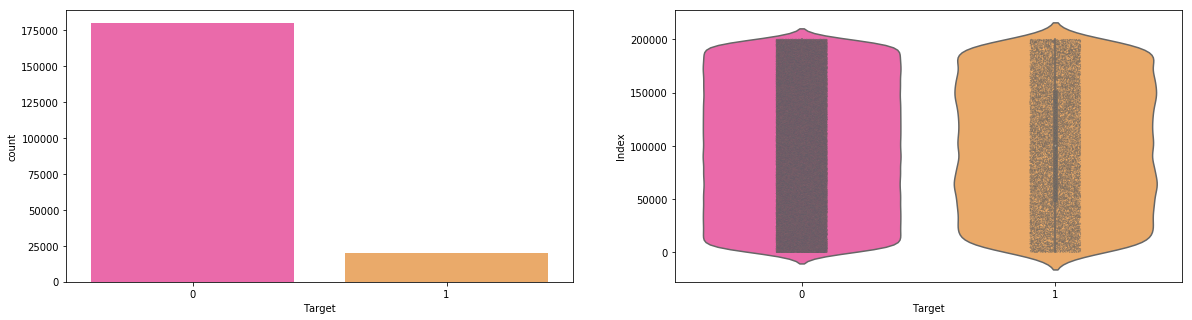

Observation:

- We are having a unbalanced data, where 90% of the data is no. of customers who will not make a transaction & 10 % of  
  the data are those who will make a transaction.
- From the violin plots, it seems that there is no relationship between the target and index of the data frame, it is 
  more dominated by zero compare to one's.
- From the jitter plots with violin plots, we can observe that target looks uniformly distributed over the indexes of   
  the data frame.

### Correlation analysis
Check for correlations between individual features:

In [34]:
train.corr()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,6.673085e-02,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,6.982549e-03,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,3.257729e-03,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,8.825211e-04,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-7.743892e-04,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.010915,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,4.882529e-05,0.004549,0.001194,...,0.001514,0.004357,0.003347,0.000813,-0.000068,0.003706,0.000513,-0.000046,-0.001821,-0.000786
var_5,0.030979,0.003046,-0.000902,0.001569,0.003253,-0.001368,1.000000,2.587780e-03,-0.000995,0.000147,...,0.001466,-0.000022,0.001116,-0.002237,-0.002543,-0.001274,0.002880,-0.000535,-0.000953,0.002767
var_6,0.066731,0.006983,0.003258,0.000883,-0.000774,0.000049,0.002588,1.000000e+00,-0.002548,-0.001188,...,0.000721,0.005604,-0.002563,0.002464,-0.001141,0.001244,0.005378,-0.003565,-0.003025,0.006096
var_7,-0.003025,0.002429,0.001511,-0.000991,0.002500,0.004549,-0.000995,-2.547746e-03,1.000000,0.000814,...,-0.000337,-0.003957,0.001733,0.003219,-0.000270,0.001854,0.001045,0.003466,0.000650,-0.001457
var_8,0.019584,0.004962,0.004098,0.002648,0.003553,0.001194,0.000147,-1.187995e-03,0.000814,1.000000,...,0.002923,-0.001151,-0.000429,0.001414,0.001313,0.001396,-0.003242,-0.004583,0.002950,0.000854


In [35]:
test.corr()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,0.004234,0.002625,0.000847,-0.004252,0.002274,0.001930,-0.004654,-0.003669,0.001427,...,0.002662,0.001151,0.001102,0.002756,-0.003509,0.001446,-0.000754,-0.000382,-0.004068,0.001248
var_1,0.004234,1.000000,0.002912,-0.002148,0.000716,0.001393,0.003567,0.003024,0.000778,-0.002643,...,0.002032,0.003477,-0.003454,0.000345,0.000126,0.001339,-0.001627,-0.002839,-0.003024,0.001861
var_2,0.002625,0.002912,1.000000,-0.005882,0.003657,0.000283,-0.001141,-0.000273,0.001231,0.000041,...,-0.001765,0.001144,-0.005496,0.002027,-0.002396,0.001333,-0.002400,-0.002726,-0.001537,0.000229
var_3,0.000847,-0.002148,-0.005882,1.000000,-0.000959,0.001644,-0.003074,0.001945,-0.001443,-0.001291,...,-0.001630,0.002119,0.001269,-0.006136,0.000289,0.001601,0.003177,0.002780,-0.002625,-0.003034
var_4,-0.004252,0.000716,0.003657,-0.000959,1.000000,0.004822,-0.003284,-0.000167,0.003138,0.000093,...,-0.003106,0.002473,-0.000734,-0.000754,-0.000427,0.003046,-0.001317,0.000425,-0.002146,0.000401
var_5,0.002274,0.001393,0.000283,0.001644,0.004822,1.000000,-0.003555,0.002837,0.001955,0.002249,...,-0.000660,0.002662,-0.002652,-0.001209,0.000997,0.002676,-0.002445,-0.003665,-0.004626,0.001638
var_6,0.001930,0.003567,-0.001141,-0.003074,-0.003284,-0.003555,1.000000,0.001845,0.002115,-0.001948,...,0.002521,0.000868,-0.002712,-0.004494,-0.002502,0.000980,-0.001602,-0.003378,0.000943,0.002023
var_7,-0.004654,0.003024,-0.000273,0.001945,-0.000167,0.002837,0.001845,1.000000,-0.000650,0.002839,...,-0.000509,0.003828,0.001511,0.001616,-0.002229,0.004812,0.001645,0.001451,-0.000810,0.000624
var_8,-0.003669,0.000778,0.001231,-0.001443,0.003138,0.001955,0.002115,-0.000650,1.000000,-0.002118,...,-0.000216,0.000244,-0.000021,-0.003302,0.000098,-0.003241,0.002765,-0.002954,-0.001544,-0.000370
var_9,0.001427,-0.002643,0.000041,-0.001291,0.000093,0.002249,-0.001948,0.002839,-0.002118,1.000000,...,0.000553,0.000994,-0.001879,0.000900,0.001122,-0.002854,0.001325,0.002241,-0.002259,0.001514


In [3]:
r2 = pd.concat([train.drop(['target', 'ID_code'], axis=1), test.drop('ID_code', axis=1)]).corr()**2
r2 = np.tril(r2, k=-1)  # remove upper triangle and diagonal
r2[r2 == 0] = np.nan # replace 0 with nan

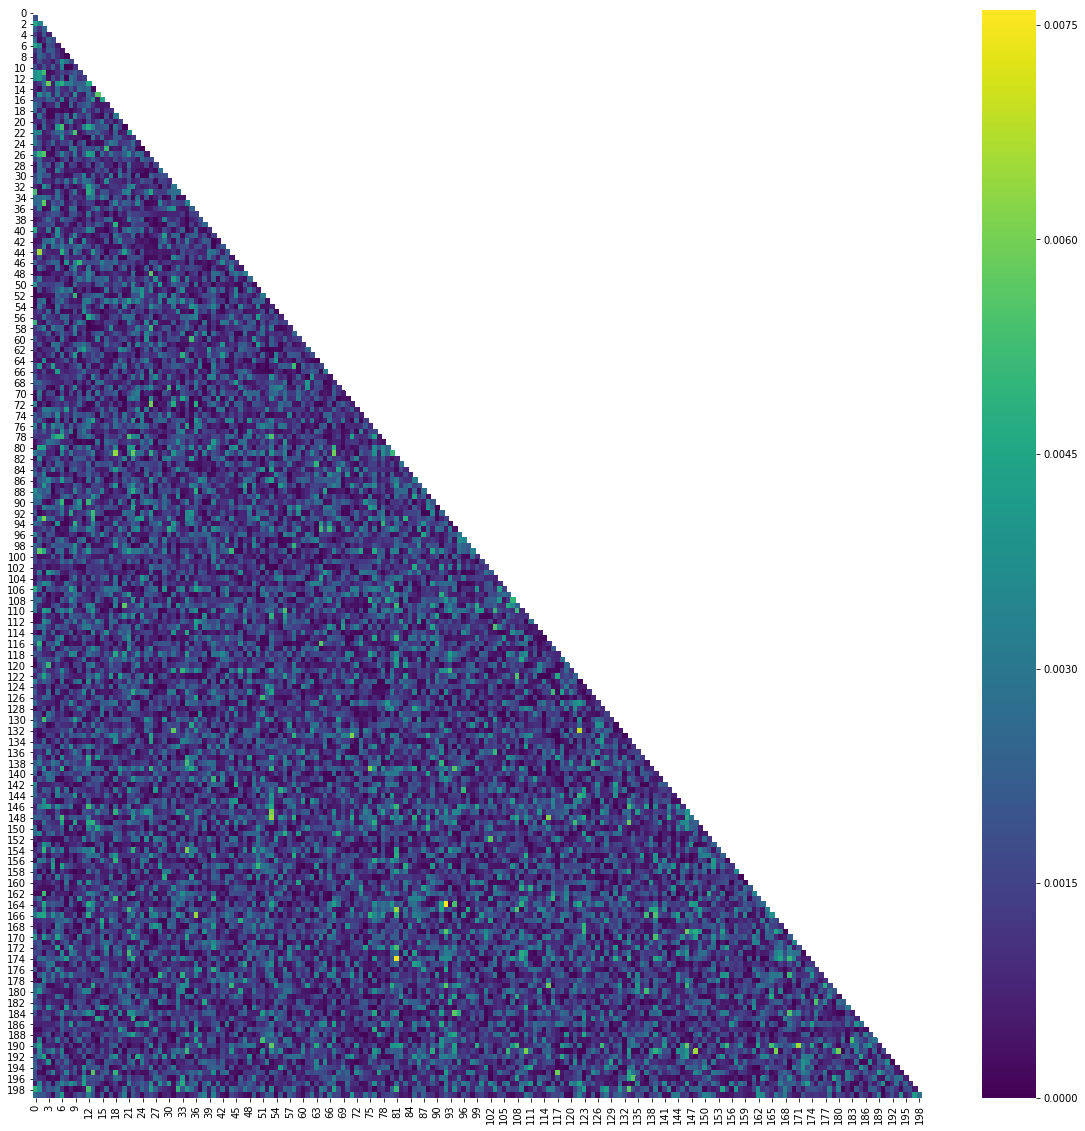

In [4]:
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(np.sqrt(r2), annot=False,cmap='viridis', ax=ax)

Explained absolute variation between individual features is small (< 1%). All features seem to be highly independent from each other.

What about correlations between features and target?

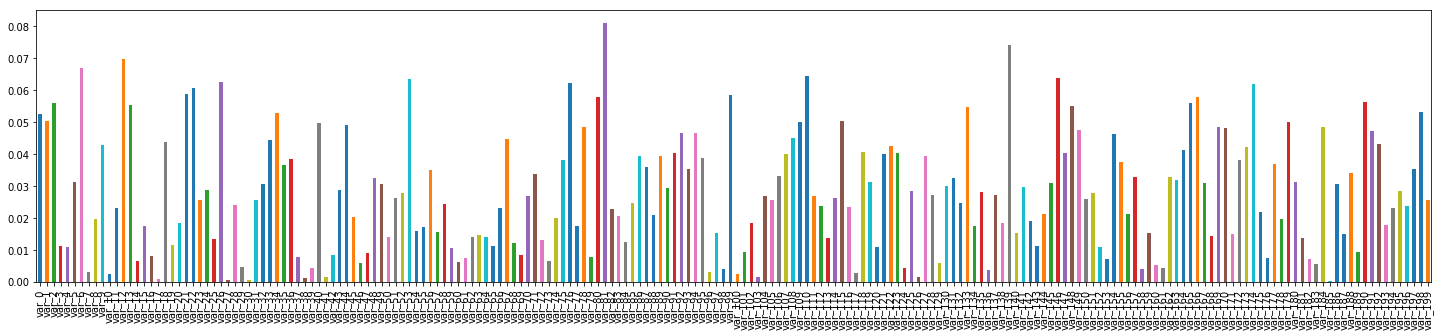

In [5]:
target_r2 = train.drop(['ID_code', 'target'], axis=1).corrwith(train.target).agg('square')

f, ax = plt.subplots(figsize=(25,5))
target_r2.agg('sqrt').plot.bar(ax=ax)

## Data Visualization

### Density plots of features
Let's show now the density plot of variables in train dataset.

We represent with different colors the distribution for values with target value 0 and 1.

In [17]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

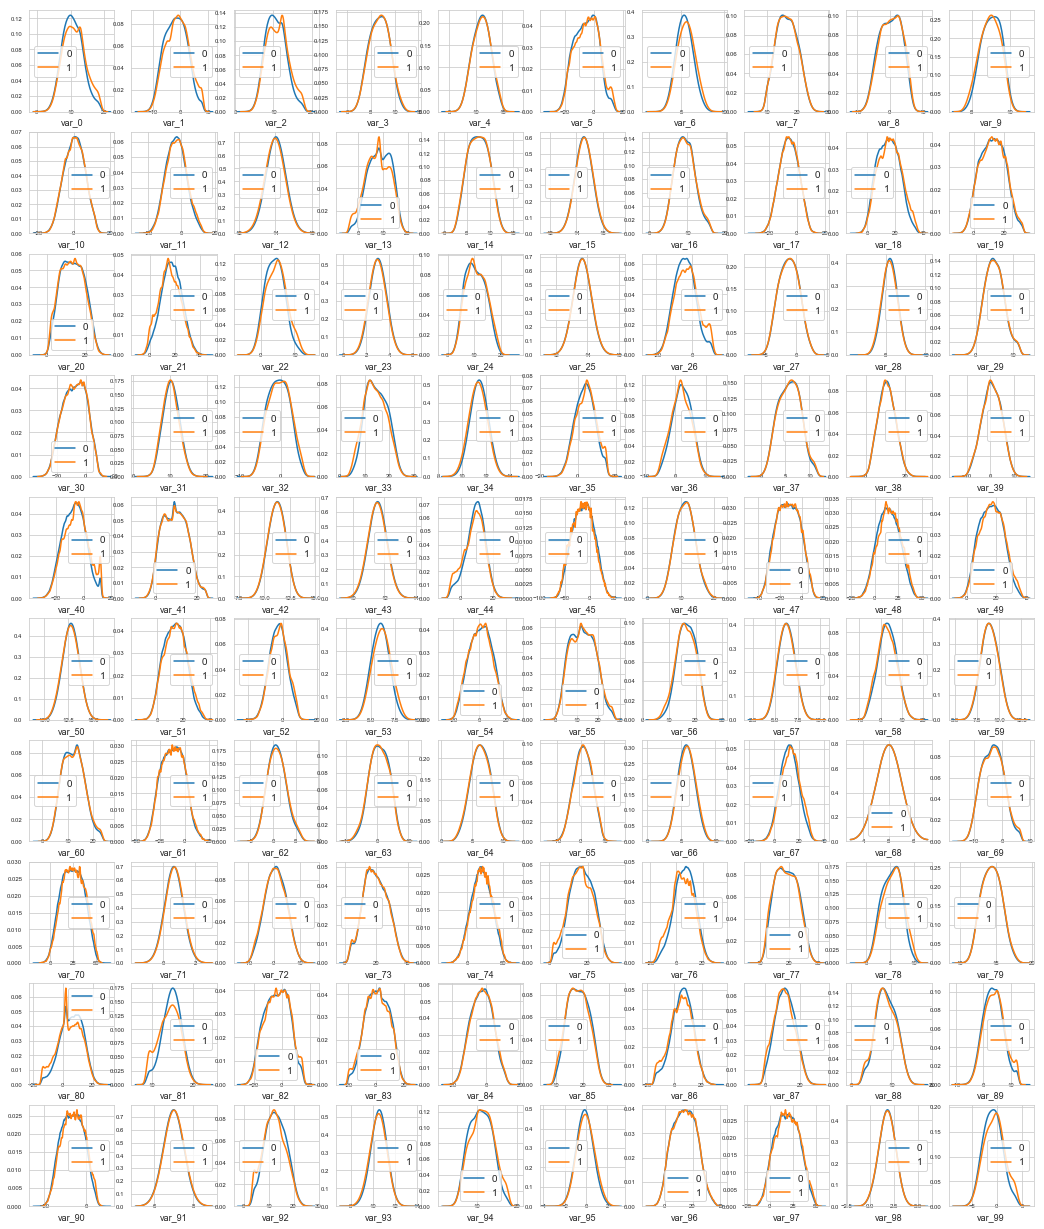

Wall time: 15.8 s


In [20]:
%%time
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

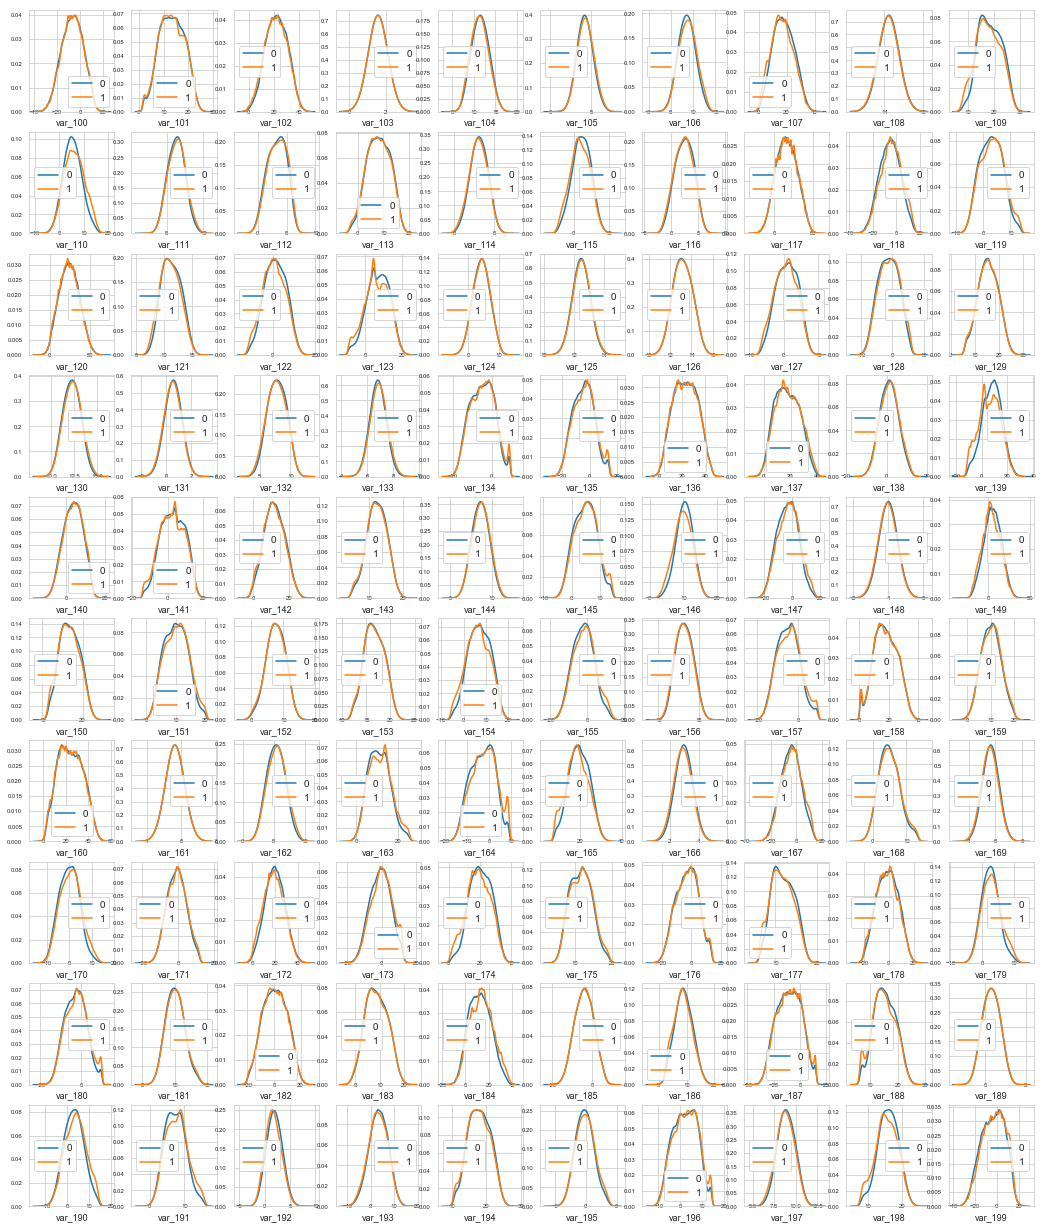

Wall time: 12.4 s


In [21]:
%%time

features = train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

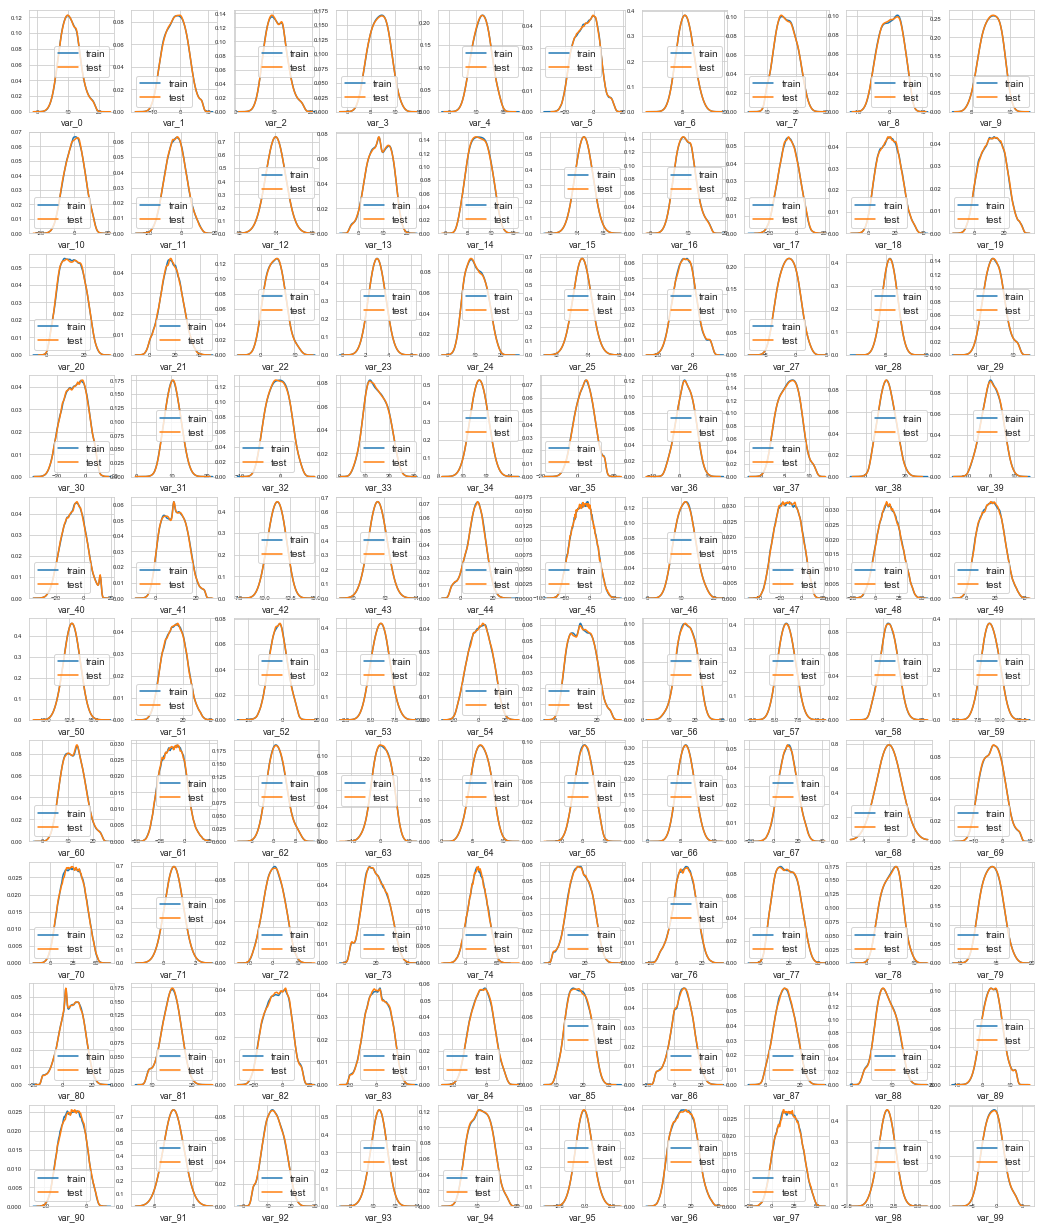

Wall time: 12.4 s


In [23]:
%%time

features = train.columns.values[2:102]
plot_feature_distribution(train, test, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

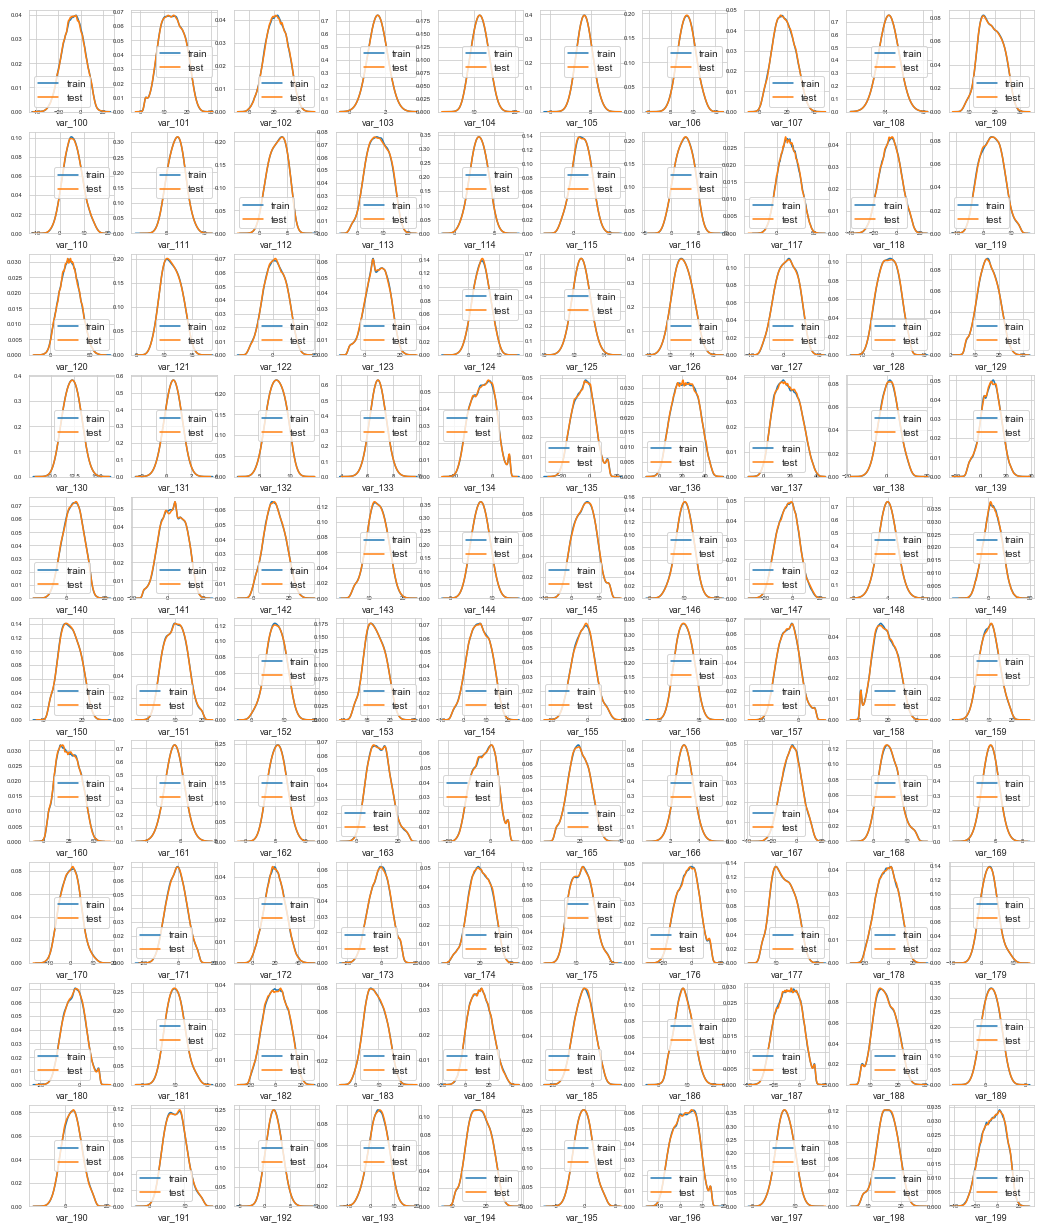

Wall time: 19.7 s


In [24]:
%%time

features = train.columns.values[102:202]
plot_feature_distribution(train, test, 'train', 'test', features)

### Distribution of mean and std
Let's check the distribution of the mean values per row in the train and test set.

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


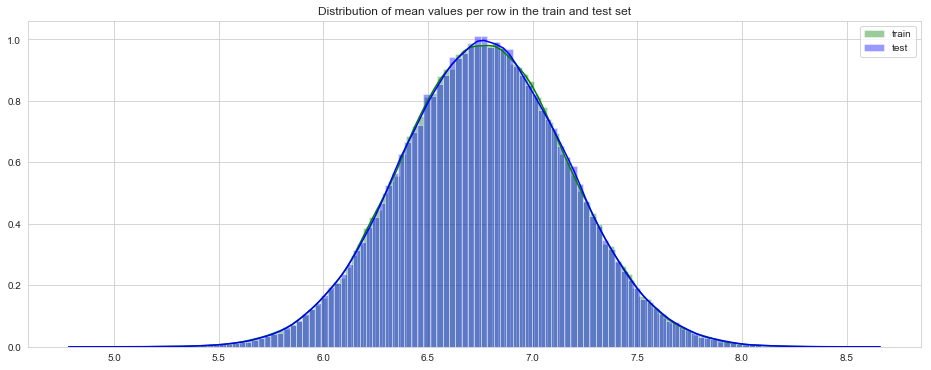

In [25]:
plt.figure(figsize=(16,6))
features = train.columns.values[(2:202)]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()


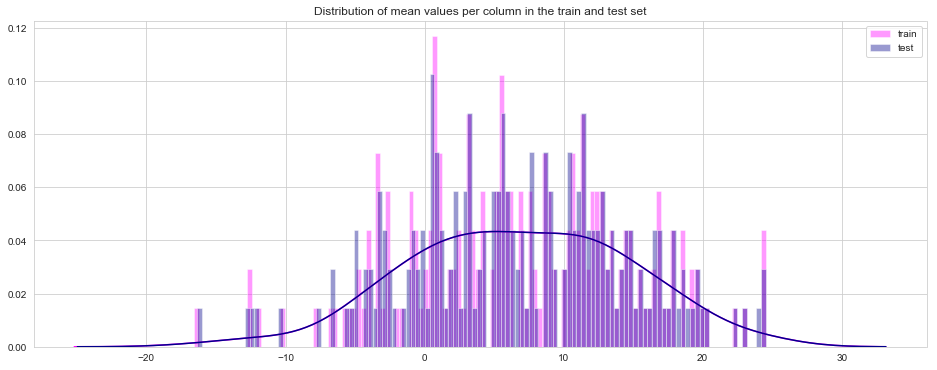

Wall time: 1.19 s


In [26]:
%%time

plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()


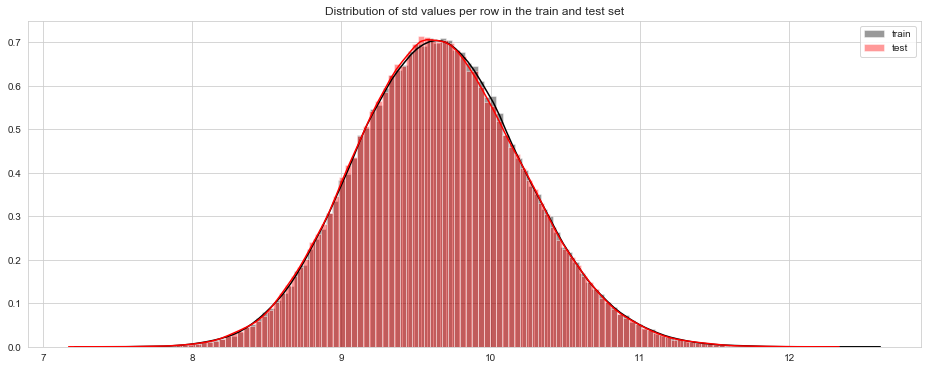

In [28]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()


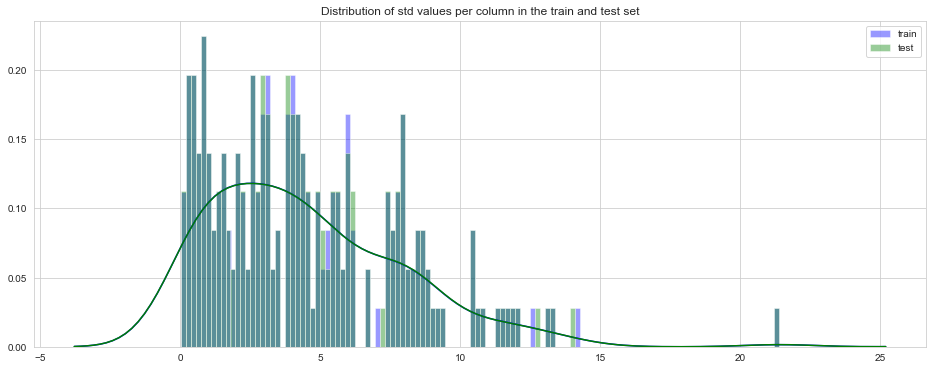

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

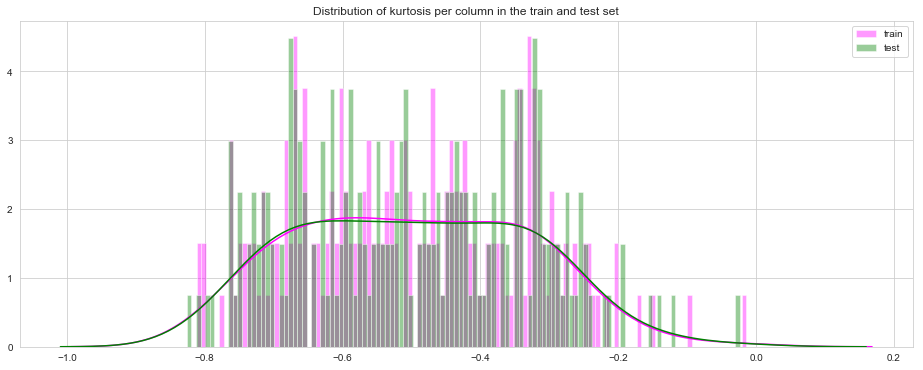

In [30]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

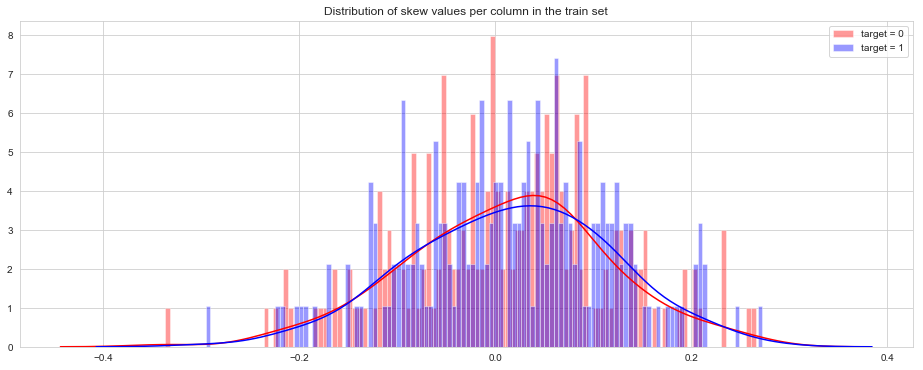

In [31]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

## Predictive Analysis Modeling
---

In [1]:
%%html
<iframe src="https://lightgbm.readthedocs.io/en/latest/" width="1000" height="300"></iframe>

In [56]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [57]:
@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)
        
        
    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

## Parameters Tuning Guide

In [5]:
%%html
<iframe src="https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html" width="1000" height="300"></iframe>

## Parameter Tuning
---

In [6]:
%%html
<iframe src="https://buildmedia.readthedocs.org/media/pdf/lightgbm/latest/lightgbm.pdf" width="1000" height="300"></iframe>

In [58]:
param = {
    'bagging_freq': 5,  #handling overfitting
    'bagging_fraction': 0.335,  #handling overfitting - adding some noise
    'bagging_seed': 7,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,#handling overfitting
    'learning_rate': 0.08,
    'reg_alpha': 1.728910519108444,
    'reg_lambda': 4.9847051755586085,
    'subsample': 0.81,
    'min_gain_to_split': 0.01077313523861969,
    'min_child_weight': 19.428902804238373,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [59]:
num_folds = 11
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=44000)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

# Logistic Regression Model:-

In [ ]:
#Training Data:
X=df_train.drop(['ID_code','target'],axis=1)
Y=df_train['target']

#Stratified KFold Cross Validator:-
skf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, valid_index in skf.split(X,Y): 
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] 
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    
print('Shape of X_train :',X_train.shape)
print('Shape of X_valid :',X_valid.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_valid :',y_valid.shape)

Shape of X_train : (160001, 200)

Shape of X_valid : (39999, 200)

Shape of y_train : (160001,)

Shape of y_valid : (39999,)

In [ ]:
%%time
lr_model=LogisticRegression(random_state=42)
#fitting the model-
lr_model.fit(X_train,y_train)

In [ ]:
#Accuracy of model-
lr_score=lr_model.score(X_train,y_train)
print('Accuracy of lr_model :',lr_score)

Accuracy of lr_model : 0.9148942819107381

In [ ]:
%%time
#Cross validation prediction of lr_model-
cv_predict=cross_val_predict(lr_model,X_valid,y_valid,cv=5)
#Cross validation score-
cv_score=cross_val_score(lr_model,X_valid,y_valid,cv=5)
print('cross val score :',np.average(cv_score))

cross val score : 0.9116728528566072

Wall time: 13min 24s

# Confusion Matrix:-

In [ ]:
#Confusion matrix:-
cm=confusion_matrix(y_valid,cv_predict)
cm=pd.crosstab(y_valid,cv_predict)
cm

      col_0  0	1

    target

    0	35436	544
    1	2989	1030

In [ ]:
#ROC_AUC SCORE:-
roc_score=roc_auc_score(y_valid,cv_predict)
print('ROC Score:',roc_score)

In [ ]:
#ROC_AUC_Curve:-
plt.figure()
false_positive_rate,recall,thresholds=roc_curve(y_valid,cv_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate,recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

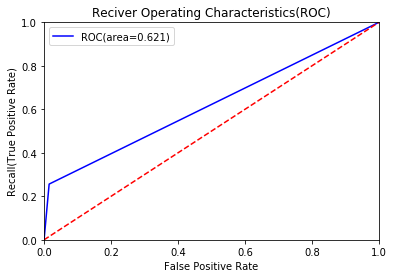

AUC: 0.620581573269051

**Observation:-** On comparing roc_auc_score and model accuracy, model is not performing well on imbalanced data.

In [ ]:
#Classification Report:-
scores=classification_report(y_smote_v,cv_pred)
print(scores)

Observation:- As we see that f1 score is high for the customers who will not make a transaction, as well as who will make a transaction.

In [ ]:
%%time
#Predicting the model-
X_test=df_test.drop(['ID_code'],axis=1)
smote_pred=smote.predict(X_test)
print(smote_pred)

Observation:- We can observe that the smote model is performing well on imbalance data as compare to logistic regression.

**Light GBM:-** It is a gradient boosting framework that uses tree based learning algorithm.

In [ ]:
#Training lgbm model:-
num_rounds=10000
lgbm= lgb.train(params,lgb_train,num_rounds,valid_sets=[lgb_train,lgb_valid],verbose_eval=1000,early_stopping_rounds = 5000)
lgbm

In [60]:
%%time

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, 
                    early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
        
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


Light GBM Model
Fold idx:1
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1230]	training's auc: 0.920857	valid_1's auc: 0.899292
Fold idx:2
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1253]	training's auc: 0.921101	valid_1's auc: 0.896861
Fold idx:3
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1076]	training's auc: 0.919204	valid_1's auc: 0.89082
Fold idx:4
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1129]	training's auc: 0.919495	valid_1's auc: 0.900598
Fold idx:5
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1413]	training's auc: 0.923708	valid_1's auc: 0.896908
Fold idx:6
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1340]	training's auc: 0.922363	valid_1's auc

In [61]:
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


 >> CV score: 0.89917 


# Conclusion:- 
We have tried with diff model like Logistic regression,smote & lightgbm. But we observed that light gbm is performing well on imbalanced data as compare to other models based on the roc_auc scores.

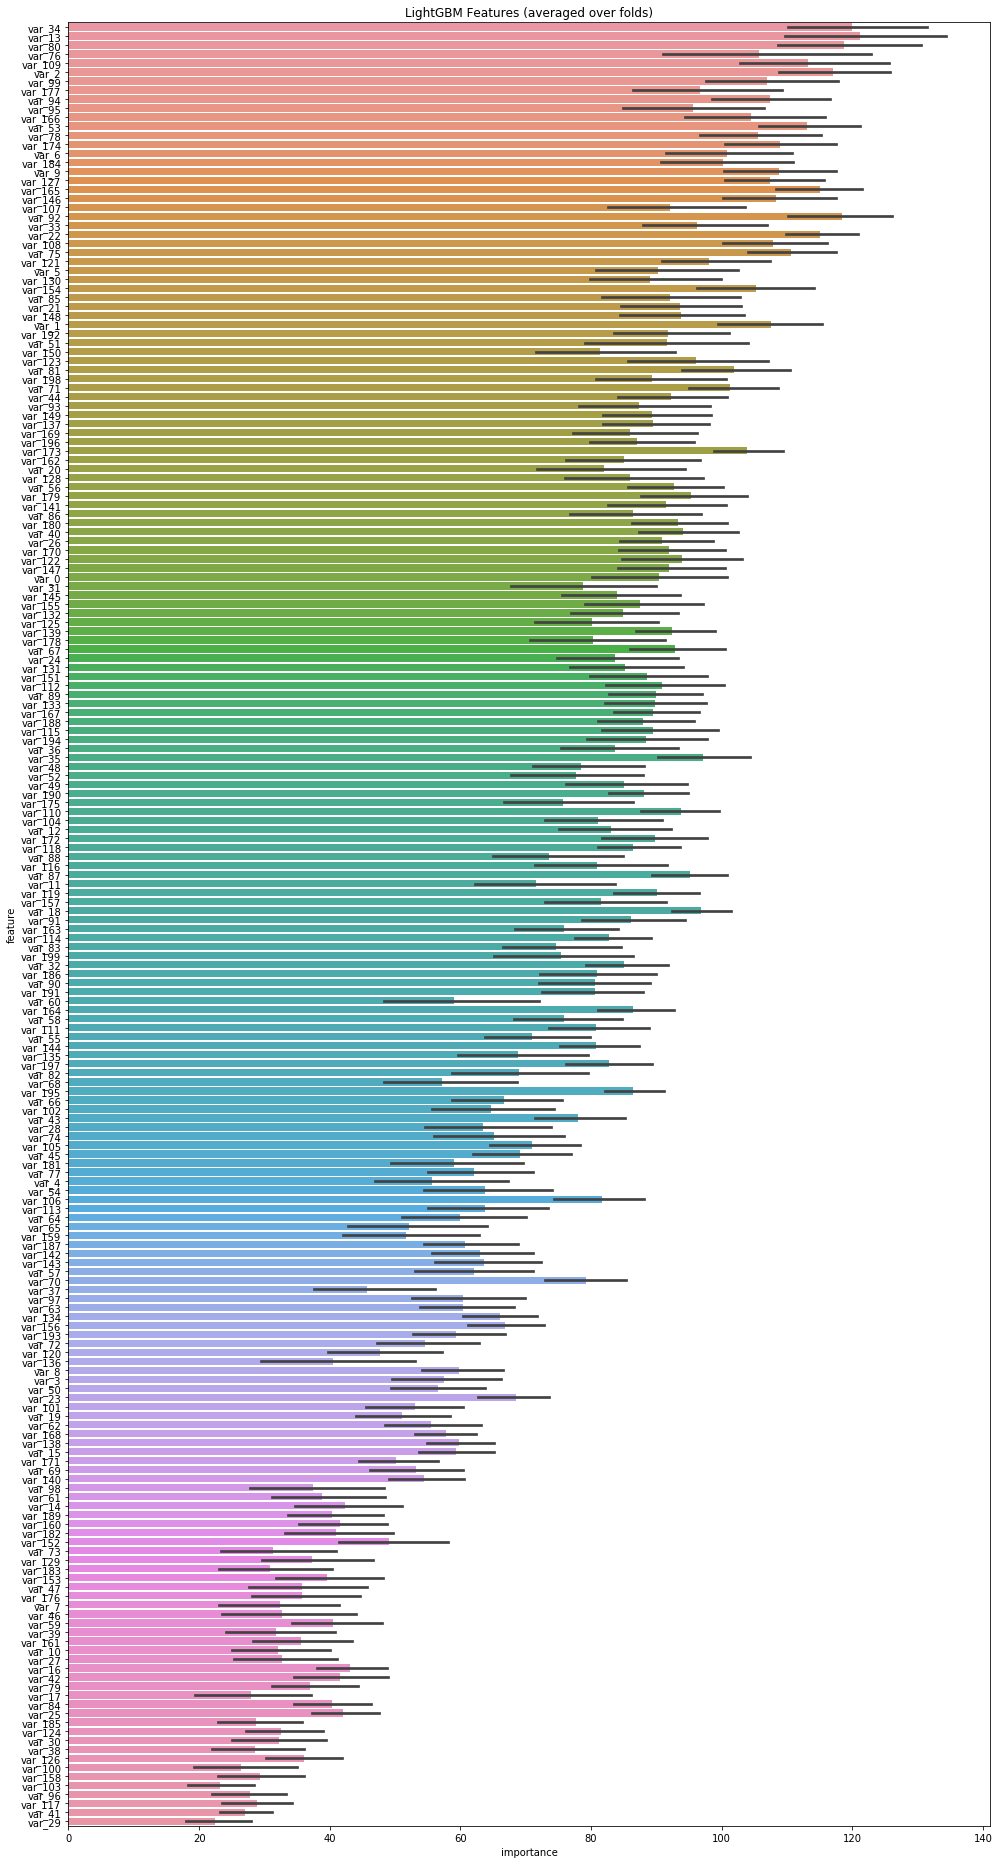

In [11]:

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [63]:
submission = pd.DataFrame({"ID_code": test.ID_code.values})
submission["target"] = predictions
submission.to_csv("submission_final.csv", index=False)